In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:

#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

In [ ]:
%ls

In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
%pip install -q mtcnn

In [ ]:
# example of extracting and resizing faces into a new dataset
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot

# load an image as an rgb numpy array
def load_image(filename):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	return pixels

# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
	# detect face in the image
	faces = model.detect_faces(pixels)
	# skip cases where we could not detect a face
	if len(faces) == 0:
		return None
	# extract details of the face
	x1, y1, width, height = faces[0]['box']
	# force detected pixel values to be positive (bug fix)
	x1, y1 = abs(x1), abs(y1)
	# convert into coordinates
	x2, y2 = x1 + width, y1 + height
	# retrieve face pixels
	face_pixels = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face_pixels)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
	# prepare model
	model = MTCNN()
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# load the image
		pixels = load_image(directory + filename)
		# get face
		face = extract_face(model, pixels)
		if face is None:
			continue
		# store
		faces.append(face)
		print(len(faces), face.shape)
		# stop once we have enough
		if len(faces) >= n_faces:
			break
	return asarray(faces)

# directory that contains all images
directory = '/content/gdrive/My Drive/datasets/img_align_celeba/'
# load and extract all faces
all_faces = load_faces(directory, 1000)
print('Loaded: ', all_faces.shape)
# save in compressed format
savez_compressed('img_align_celeba_1000.npz', all_faces)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/datasets/50000

/content/gdrive/My Drive/datasets/50000


In [ ]:
%ls -alh

total 896M
-rw------- 1 root root  98K Aug  7 12:43 generated_plot_e010.png
-rw------- 1 root root  95K Aug  7 13:09 generated_plot_e020.png
-rw------- 1 root root  95K Aug  7 13:34 generated_plot_e030.png
-rw------- 1 root root  99K Aug  7 14:00 generated_plot_e040.png
-rw------- 1 root root  94K Aug  7 14:26 generated_plot_e050.png
-rw------- 1 root root  95K Aug  7 14:52 generated_plot_e060.png
-rw------- 1 root root  93K Aug  7 15:18 generated_plot_e070.png
-rw------- 1 root root  95K Aug  7 15:44 generated_plot_e080.png
-rw------- 1 root root  94K Aug  7 16:10 generated_plot_e090.png
-rw------- 1 root root 5.4M Aug  7 12:43 generator_model_010.h5
-rw------- 1 root root 5.4M Aug  7 13:09 generator_model_020.h5
-rw------- 1 root root 5.4M Aug  7 13:34 generator_model_030.h5
-rw------- 1 root root 5.4M Aug  7 14:00 generator_model_040.h5
-rw------- 1 root root 5.4M Aug  7 14:26 generator_model_050.h5
-rw------- 1 root root 5.4M Aug  7 14:52 generator_model_060.h5
-rw------- 1 root ro

In [ ]:
# load the prepared dataset
from numpy import load
# load the face dataset
data = load('img_align_celeba.npz')
faces = data['arr_0']
print('Loaded: ', faces.shape)

Loaded:  (1500, 80, 80, 3)


In [ ]:
# example of a gan for generating faces
from numpy import load
from numpy import zeros
from numpy import ones

from numpy.random import randn
from numpy.random import randint

from keras.optimizers import Adam
from keras.models import Sequential

from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 40x40
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 20x30
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 10x10
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 5x5
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 5x5 feature maps
	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
	# upsample to 10x10
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 20x20
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 40x40
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 80x80
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 80x80x3
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare training images
def load_real_samples():
	# load the face dataset
	data = load('img_align_celeba_50000.npz')
	X = data['arr_0']
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>66, 339/390, d1=0.127, d2=0.264 g=3.708
>66, 340/390, d1=0.130, d2=0.096 g=4.161
>66, 341/390, d1=0.164, d2=0.117 g=3.519
>66, 342/390, d1=0.225, d2=0.332 g=4.255
>66, 343/390, d1=0.434, d2=0.234 g=3.722
>66, 344/390, d1=0.136, d2=0.071 g=3.850
>66, 345/390, d1=0.343, d2=0.168 g=3.655
>66, 346/390, d1=0.333, d2=0.146 g=2.981
>66, 347/390, d1=0.046, d2=0.145 g=3.682
>66, 348/390, d1=0.259, d2=0.104 g=3.737
>66, 349/390, d1=0.195, d2=0.192 g=3.607
>66, 350/390, d1=0.110, d2=0.224 g=4.362
>66, 351/390, d1=0.222, d2=0.056 g=3.655
>66, 352/390, d1=0.089, d2=0.193 g=4.422
>66, 353/390, d1=0.124, d2=0.045 g=4.369
>66, 354/390, d1=0.175, d2=0.297 g=4.340
>66, 355/390, d1=0.122, d2=0.041 g=4.403
>66, 356/390, d1=0.121, d2=0.075 g=3.817
>66, 357/390, d1=0.155, d2=0.139 g=3.587
>66, 358/390, d1=0.105, d2=0.208 g=4.585
>66, 359/390, d1=0.269, d2=0.097 g=3.859
>66, 360/390, d1=0.370, d2=0.357 g=4.041
>66, 361/390, d1=0.230, d2=0.193 g=4.439
>66, 3

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_090.h5')

[[ 0.86069396  1.39267665  0.29071741 -0.26576879 -1.6723293  -0.60238524
  -2.9011834  -0.27799399 -1.37752404 -0.83087917 -0.42674499  0.50005905
   0.4655283   1.07274089  0.24657518 -0.42039056  0.82242178 -0.43301253
  -0.46589659  0.93662807 -0.04860721 -0.39611663  0.81225591 -1.73895079
  -0.26446156  0.50576279 -1.33906062 -1.11921027 -0.35651741 -1.19586849
   0.08175754  0.19202703  0.22409365  0.748081   -0.99242592 -0.55577008
  -0.48103622 -0.99613452 -0.04011838  0.03295857 -2.08380082  1.15047261
   0.0652569   0.26040584 -0.07294131 -0.0099668  -0.74426955  0.71417412
   0.32259527 -1.99701248 -1.72388315 -0.85598248  1.06112351  1.41667591
   0.40472591  0.34021511  0.47768083  0.46458294 -1.03533843  0.7405599
  -1.3498991  -0.40341583 -0.39558076  0.09068198  0.72635817  0.87241313
  -0.84436447  1.3266865  -1.6898727  -1.67132593 -0.62781531  1.76553718
   0.6768878   0.312278   -1.31100252 -0.17906397 -0.41016416 -1.16623121
  -1.05299055  1.11744854 -1.17278196 -

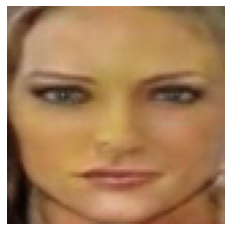

In [ ]:

# generate images
nsamples = 1
latent_points = generate_latent_points(100, nsamples**2)
print(latent_points)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, nsamples)

In [ ]:
# man
point_a = [[ 0.19006739,  -0.38826548,   0.46376296,  -2.27353012,  -1.97333904,  -0.73712647, 
  -1.16729007,  0.26081011, -0.34356559,  0.45771236,  0.27138751,  0.46388373,
  -0.78720124,  0.9351005,   1.32082433, -0.44255239, -0.2197874 ,  0.12335594,
   1.3908479,  -2.45132029,  0.31568583, -0.99400511,  1.85890502,  1.8535437,
  -1.49886234, -0.78862487, -0.78551676,  0.08979   , -1.08399102, -1.11348247,
  -1.67873137,  0.2137995,   1.26522761, -1.37571459, -0.49431107, -0.82935855,
   0.15915021, -0.36148661,  1.22028061, -0.5880294 ,  1.46253298,  1.16961182,
  -1.32094835,  1.47242106, -2.09867026, -0.34205411, -1.61408211,  1.04255336,
   0.41403329, -0.70540635,  1.87259644, -1.53602141, -0.92849846, -1.66983367,
  -0.75765831,  0.5998416,  -1.25849729,  0.49094535,  0.31498247, -1.22704697,
  -0.85989012, -1.0843165,  -0.04932274, -0.29067657,  1.885972  , -0.03656365,
   1.17060666,  0.03081126,  0.24888664, -0.70910202, -0.60788825, -1.50795708,
  -0.7266065,  -1.49008215, -1.76479872, -2.27881124, -0.38137287,  1.14818886,
   1.05472505,  1.81953003,  2.31290637,  0.46824403, -0.76279212, -1.03977082,
   0.85425178,  0.07506486,  1.11762263,  0.53427754, -0.09886472,  1.33599621,
   0.38343333, -0.43227812, -1.5089457 ,  1.60033676, -1.55486221,  2.28342611,
  -1.04861917, -0.28181926, -0.15580576, -0.36232268]]


[[0.19006739, -0.38826548, 0.46376296, -2.27353012, -1.97333904, -0.73712647, -1.16729007, 0.26081011, -0.34356559, 0.45771236, 0.27138751, 0.46388373, -0.78720124, 0.9351005, 1.32082433, -0.44255239, -0.2197874, 0.12335594, 1.3908479, -2.45132029, 0.31568583, -0.99400511, 1.85890502, 1.8535437, -1.49886234, -0.78862487, -0.78551676, 0.08979, -1.08399102, -1.11348247, -1.67873137, 0.2137995, 1.26522761, -1.37571459, -0.49431107, -0.82935855, 0.15915021, -0.36148661, 1.22028061, -0.5880294, 1.46253298, 1.16961182, -1.32094835, 1.47242106, -2.09867026, -0.34205411, -1.61408211, 1.04255336, 0.41403329, -0.70540635, 1.87259644, -1.53602141, -0.92849846, -1.66983367, -0.75765831, 0.5998416, -1.25849729, 0.49094535, 0.31498247, -1.22704697, -0.85989012, -1.0843165, -0.04932274, -0.29067657, 1.885972, -0.03656365, 1.17060666, 0.03081126, 0.24888664, -0.70910202, -0.60788825, -1.50795708, -0.7266065, -1.49008215, -1.76479872, -2.27881124, -0.38137287, 1.14818886, 1.05472505, 1.81953003, 2.3129

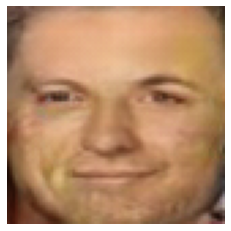

In [ ]:
print(point_a)
X  = model.predict(point_a)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 1)

In [ ]:
# woman white kinda blonde XDDD
point_b = [[-0.53984334, -1.06177782, -0.43932985, -0.16038531,  0.09406998, -0.02274019,
   1.15527474, -0.95268688, -0.46236945,  0.56264772, -0.14552754, -2.35398766,
   1.35597312,  1.54975348,  0.4532762 , -0.42106355, -1.5232478 ,  0.78889209,
   0.42147465, -0.89329714, -1.91732388,  1.53694706,  1.68671043,  0.4449837,
  -1.33672113, -0.04444093,  1.17275069, -0.80997827, -0.67432841,  0.66752903,
  -1.96616844, -0.1264231 , -1.81591531, -0.84601162,  1.98682968, -0.0521441,
   1.03479548, -1.42576684, -1.94277788,  1.1410851 ,  0.657761  , -0.45631594,
   0.01365224,  0.23309406,  0.22972976, -0.4769241 ,  0.22116467, -0.29933224,
  -0.40854606, -0.22278106,  1.05748597,  1.37249443,  0.05259777, -2.46625575,
   0.77710313,  0.54637538,  1.24549435, -0.71502588,  0.02246348,  0.79312114,
   0.54359557, -1.59617374,  1.50083325, -0.74875609, -0.96644462, -0.77487208,
   0.95971729, -0.3529998 ,  2.9706714 , -0.5008103 ,  0.06376184,  1.53961505,
  -1.4771907 ,  0.69194278, -1.07391141,  0.67629428, -1.50340779, -1.23152526,
   0.95585916,  0.35364246,  0.66718467,  0.53518814, -0.72542323,  0.98240836,
   0.01601638, -1.51942172, -0.01098601,  0.27472434, -0.92448127, -0.53774938,
  -0.30100491, -0.55831805, -0.44473305,  0.12733786, -1.56498439, -0.68978027,
  -0.75785667, -0.9541124 ,  0.51438741, -1.00976442]]

[[-0.53984334, -1.06177782, -0.43932985, -0.16038531, 0.09406998, -0.02274019, 1.15527474, -0.95268688, -0.46236945, 0.56264772, -0.14552754, -2.35398766, 1.35597312, 1.54975348, 0.4532762, -0.42106355, -1.5232478, 0.78889209, 0.42147465, -0.89329714, -1.91732388, 1.53694706, 1.68671043, 0.4449837, -1.33672113, -0.04444093, 1.17275069, -0.80997827, -0.67432841, 0.66752903, -1.96616844, -0.1264231, -1.81591531, -0.84601162, 1.98682968, -0.0521441, 1.03479548, -1.42576684, -1.94277788, 1.1410851, 0.657761, -0.45631594, 0.01365224, 0.23309406, 0.22972976, -0.4769241, 0.22116467, -0.29933224, -0.40854606, -0.22278106, 1.05748597, 1.37249443, 0.05259777, -2.46625575, 0.77710313, 0.54637538, 1.24549435, -0.71502588, 0.02246348, 0.79312114, 0.54359557, -1.59617374, 1.50083325, -0.74875609, -0.96644462, -0.77487208, 0.95971729, -0.3529998, 2.9706714, -0.5008103, 0.06376184, 1.53961505, -1.4771907, 0.69194278, -1.07391141, 0.67629428, -1.50340779, -1.23152526, 0.95585916, 0.35364246, 0.66718467

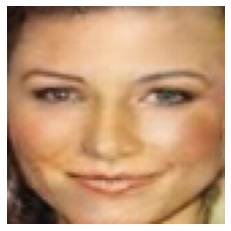

In [ ]:
print(point_b)
X  = model.predict(point_b)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 1)

In [ ]:
# woman kinda asian XD black hair
point_c = [[ 0.93365062, -0.27817271, -0.41998597,  1.17106126,  0.67556602,  0.71976662,
   1.30104663,  0.34831055,  0.21157966,  0.93462997,  1.97556902, -0.05103441,
   1.24352989,  0.96671347,  0.27612965,  1.63316618,  0.25522622,  1.38124202,
  -0.95957682, -0.86864235,  0.83484611,  1.63274361,  1.73920818, -0.56385902,
  -0.55785573, -0.66301342,  1.12106193,  1.25139855,  1.03974802, -1.60375489,
   0.45424449, -1.50024719,  0.11508398,  1.08050099,  0.41276945, -0.40683972,
   0.20393128,  0.10430434, 1.60483065 , 0.72812776 , 0.4469411  , 0.47661151,
   1.55315146,  0.81009711, -0.40370616,  2.23059506,  0.11171882,  1.96196501,
  -1.07640501, -0.61718644, -1.14962474, -0.56331305, -0.73186157, -0.31028698,
   2.04407531, -0.0424177 ,  1.39525286, -1.01602937, -0.26799673, -1.40974839,
   0.20426463, -0.70793179,  1.95892059, -0.27718787, -0.22070014, -0.68032211,
   0.22939143,  0.91558501,  0.35049273, -2.21563202,  2.33695978, -0.30934073,
  -1.45672903,  1.61864429,  1.01137853, -0.64121097,  0.78136699,  0.55600053,
   0.59911048,  0.15375627,  0.66214956, -1.14178522,  1.54767192, -1.22312818,
   0.34957996, -0.20474416,  0.20661483, -0.06632793, -0.32643719,  1.42425354,
   0.94576116, -0.57856669,  0.44719109, -0.73261155, -0.69974741, -1.53932904,
   0.2835385 , -0.30689036,  2.03844697, -1.01255735]]

[[0.93365062, -0.27817271, -0.41998597, 1.17106126, 0.67556602, 0.71976662, 1.30104663, 0.34831055, 0.21157966, 0.93462997, 1.97556902, -0.05103441, 1.24352989, 0.96671347, 0.27612965, 1.63316618, 0.25522622, 1.38124202, -0.95957682, -0.86864235, 0.83484611, 1.63274361, 1.73920818, -0.56385902, -0.55785573, -0.66301342, 1.12106193, 1.25139855, 1.03974802, -1.60375489, 0.45424449, -1.50024719, 0.11508398, 1.08050099, 0.41276945, -0.40683972, 0.20393128, 0.10430434, 1.60483065, 0.72812776, 0.4469411, 0.47661151, 1.55315146, 0.81009711, -0.40370616, 2.23059506, 0.11171882, 1.96196501, -1.07640501, -0.61718644, -1.14962474, -0.56331305, -0.73186157, -0.31028698, 2.04407531, -0.0424177, 1.39525286, -1.01602937, -0.26799673, -1.40974839, 0.20426463, -0.70793179, 1.95892059, -0.27718787, -0.22070014, -0.68032211, 0.22939143, 0.91558501, 0.35049273, -2.21563202, 2.33695978, -0.30934073, -1.45672903, 1.61864429, 1.01137853, -0.64121097, 0.78136699, 0.55600053, 0.59911048, 0.15375627, 0.66214956

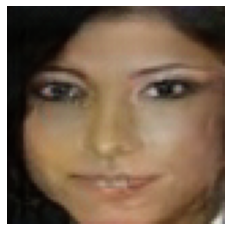

In [ ]:
print(point_c)
X  = model.predict(point_c)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 1)

In [ ]:
# woman black
point_d = [[ 1.19717693, -1.5367675,   0.32608176, -0.29677202, -0.82979404,  0.11249827,
   0.31565955,  0.03419756,  0.55538861,  1.40193613, -0.01356103, -0.47133925,
   1.49991789, -0.61784354, -0.50522313, -1.75676124,  1.56604185,  1.22136596,
   0.41033982, -1.18698916,  2.22197089,  0.36873661,  1.44333474,  0.17227177,
   0.67887681,  0.06193619, -2.41733691, -0.02331474,  0.13480855, -0.50614888,
  -0.42237524, -0.96637901,  0.26659001,  1.65186119,  0.71131718, -0.3348379,
  -0.83925062,  1.46005533,  2.13246049, -0.57650307, -0.89951631, -0.21633633,
   0.74637648, -0.88321957,  0.06669126,  0.64229351, -0.62894266, -0.85239437,
  -0.36421974, -0.6520809 ,  1.37793766, -0.62502586,  0.25837765,  1.54991359,
  -1.24972304,  1.51469779,  0.74505627, -0.93134535, -0.95256777,  0.37621861,
  -0.52295868, -0.35052299,  1.89506317, -1.2638975 , -1.42786028, -0.36871839,
  -0.75336137,  0.06591398,  0.5897714 , -0.08767796, -1.24702128, -0.44238554,
   0.061649  ,  0.44855773, -0.33424264, -0.1388147 , -0.17416448,  0.64538043,
  -0.88906625, -0.10720906,  0.21745869, -1.87751744, -1.11403713,  0.0437519,
   0.06780305,  0.28307978,  0.4291644 , -0.52927729, -0.24539506, -2.08008222,
   0.23303487,  0.54538605, -0.77436594, -0.99222549, -0.29341491,  0.18334244,
   0.84763678,  1.63637613,  0.18717592,  0.66355589]]

[[1.19717693, -1.5367675, 0.32608176, -0.29677202, -0.82979404, 0.11249827, 0.31565955, 0.03419756, 0.55538861, 1.40193613, -0.01356103, -0.47133925, 1.49991789, -0.61784354, -0.50522313, -1.75676124, 1.56604185, 1.22136596, 0.41033982, -1.18698916, 2.22197089, 0.36873661, 1.44333474, 0.17227177, 0.67887681, 0.06193619, -2.41733691, -0.02331474, 0.13480855, -0.50614888, -0.42237524, -0.96637901, 0.26659001, 1.65186119, 0.71131718, -0.3348379, -0.83925062, 1.46005533, 2.13246049, -0.57650307, -0.89951631, -0.21633633, 0.74637648, -0.88321957, 0.06669126, 0.64229351, -0.62894266, -0.85239437, -0.36421974, -0.6520809, 1.37793766, -0.62502586, 0.25837765, 1.54991359, -1.24972304, 1.51469779, 0.74505627, -0.93134535, -0.95256777, 0.37621861, -0.52295868, -0.35052299, 1.89506317, -1.2638975, -1.42786028, -0.36871839, -0.75336137, 0.06591398, 0.5897714, -0.08767796, -1.24702128, -0.44238554, 0.061649, 0.44855773, -0.33424264, -0.1388147, -0.17416448, 0.64538043, -0.88906625, -0.10720906, 0.21

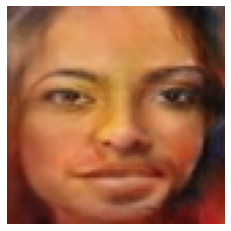

In [ ]:
print(point_d)
X  = model.predict(point_d)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 1)

In [ ]:
# a guy with a mustach
point_e = [[-1.92257393, -0.83251451, -0.29482704, -1.20452903,  0.10503086,  0.3070712,
  -1.47628449,  0.25022179, -0.55918936,  0.96502486, -1.04366371,  1.07648361,
   0.18892476, -0.70000655, -0.16937149, -1.19872087, -0.37125528, -0.33054764,
   0.61831492,  0.95379458,  0.87499156,  0.12634204,  2.26225702,  0.06954714,
   1.28126821, -0.38282571, -1.02686554,  0.62421742, -0.60324503, -1.29683723,
  -0.79655354,  0.54616964,  0.49192435, -0.27316593, -1.14506616, -1.83521233,
  -1.56793098,  0.08092712, -0.12799606, -0.44700985,  0.3521809 ,  2.17777495,
   0.67142946, -0.38587461,  0.28767976,  0.11536358,  0.88255622, -0.1274299,
   0.41501344,  0.73498233, -0.18747498,  1.21689692,  0.14300679,  0.89075398,
  -0.66749655, -1.82519598,  0.15876885,  0.57924593, -0.34690999, -0.40706092,
   0.56584725,  1.33246752, -0.5051679 ,  0.00826376, -0.00731451,  1.2475529,
  -0.01293711, -0.38521081,  0.40811586, -0.9424254 , -0.65068709, -0.69904323,
   1.2487175 , -0.87202784, -0.86274581, -1.13728913, -0.08470372, -0.37455059,
  -0.37778917, 0.87643665 , 0.30655743 , 0.16364734 ,-0.56761294 ,-0.94994101,
   0.09477425, -1.10087781, -0.90541923,  1.04562858, -0.93114318,  0.49382846,
   2.02328862, -0.00774756,  0.94582603, -0.40312555, -2.05276872, -0.5087397,
  -0.70308223, -0.75118944, -1.0425365 , -0.11864631]]

[[-1.92257393, -0.83251451, -0.29482704, -1.20452903, 0.10503086, 0.3070712, -1.47628449, 0.25022179, -0.55918936, 0.96502486, -1.04366371, 1.07648361, 0.18892476, -0.70000655, -0.16937149, -1.19872087, -0.37125528, -0.33054764, 0.61831492, 0.95379458, 0.87499156, 0.12634204, 2.26225702, 0.06954714, 1.28126821, -0.38282571, -1.02686554, 0.62421742, -0.60324503, -1.29683723, -0.79655354, 0.54616964, 0.49192435, -0.27316593, -1.14506616, -1.83521233, -1.56793098, 0.08092712, -0.12799606, -0.44700985, 0.3521809, 2.17777495, 0.67142946, -0.38587461, 0.28767976, 0.11536358, 0.88255622, -0.1274299, 0.41501344, 0.73498233, -0.18747498, 1.21689692, 0.14300679, 0.89075398, -0.66749655, -1.82519598, 0.15876885, 0.57924593, -0.34690999, -0.40706092, 0.56584725, 1.33246752, -0.5051679, 0.00826376, -0.00731451, 1.2475529, -0.01293711, -0.38521081, 0.40811586, -0.9424254, -0.65068709, -0.69904323, 1.2487175, -0.87202784, -0.86274581, -1.13728913, -0.08470372, -0.37455059, -0.37778917, 0.87643665, 0.

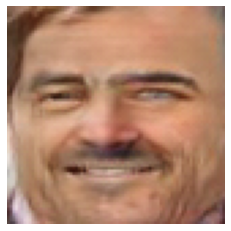

In [ ]:
print(point_e)
X  = model.predict(point_e)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 1)

In [ ]:
#  young man with mustach and a beard
point_f = [[-0.03899776,  0.19877396,  1.0074007,   0.19851723, -1.29356943, -0.49402374,
  -0.4698986,   1.40678232,  0.21013485, -0.05420428, -0.34916767, -0.50637702,
  -0.88327785,  1.37376377,  1.06739719,  0.1462667 ,  0.82837316, -0.79499522,
  -1.90536396,  0.08626104, -1.21308406, -2.07744001, -0.02601144, -1.0275138,
   0.43331728,  0.79623359,  0.19347593, -1.10963801,  0.29896435, -1.40219479,
   0.54943466,  0.37772421, -0.69331165,  0.00618777,  0.13350797,  0.69658689,
  -0.80445238, -0.48960713,  0.65828964,  0.22133983, -0.83182231,  0.64994457,
   1.04231099, -1.43224995,  1.39835099,  0.12701625,  2.26335622, -1.71815925,
  -1.646589  , -0.55979808,  0.90651245, -0.55990666,  0.30396234, -0.60262308,
   0.50784944, -0.72204539,  1.02031851,  0.12226329,  0.14197676,  0.39617456,
  -1.6929721 ,  0.73629916, -0.58885685,  0.2652494 ,  0.1157043 , -0.90578575,
  -0.60840517,  0.24015828, -0.59285994, -0.61137115, -0.23647152, -0.07162354,
   2.41273846,  1.33401932,  0.06856779, -0.13590717,  0.43465638,  1.40194314,
   0.01779119,  1.10756389,  1.43956269, -0.02287057,  0.29195626, -0.51620612,
  -0.65938423, -0.69154772, -2.55940083, -1.06075782,  0.93768472,  0.58864758,
  -1.22134161, -0.47092143,  0.15847636, -0.26997638,  1.51773561,  0.51379179,
  -0.5719379 , -0.13597358, -1.65268335,  1.06446976,]]

[[-0.03899776, 0.19877396, 1.0074007, 0.19851723, -1.29356943, -0.49402374, -0.4698986, 1.40678232, 0.21013485, -0.05420428, -0.34916767, -0.50637702, -0.88327785, 1.37376377, 1.06739719, 0.1462667, 0.82837316, -0.79499522, -1.90536396, 0.08626104, -1.21308406, -2.07744001, -0.02601144, -1.0275138, 0.43331728, 0.79623359, 0.19347593, -1.10963801, 0.29896435, -1.40219479, 0.54943466, 0.37772421, -0.69331165, 0.00618777, 0.13350797, 0.69658689, -0.80445238, -0.48960713, 0.65828964, 0.22133983, -0.83182231, 0.64994457, 1.04231099, -1.43224995, 1.39835099, 0.12701625, 2.26335622, -1.71815925, -1.646589, -0.55979808, 0.90651245, -0.55990666, 0.30396234, -0.60262308, 0.50784944, -0.72204539, 1.02031851, 0.12226329, 0.14197676, 0.39617456, -1.6929721, 0.73629916, -0.58885685, 0.2652494, 0.1157043, -0.90578575, -0.60840517, 0.24015828, -0.59285994, -0.61137115, -0.23647152, -0.07162354, 2.41273846, 1.33401932, 0.06856779, -0.13590717, 0.43465638, 1.40194314, 0.01779119, 1.10756389, 1.43956269,

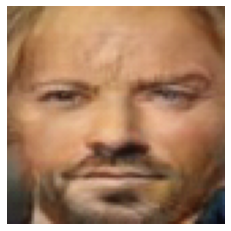

In [ ]:
print(point_f)
X  = model.predict(point_f)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 1)

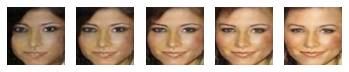

In [ ]:
# example of interpolating between generated faces
import numpy as np
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=5):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n):
		# define subplot
		pyplot.subplot(1, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_090.h5')
# generate points in latent space
#pts = generate_latent_points(100, 2)
pts = [point_a, point_c]
# interpolate points in latent space
#interpolated = interpolate_points(pts[0], pts[1])
interpolated = interpolate_points( np.array(point_c[0], dtype=np.float64)  , np.array(point_b[0], dtype=np.float64))
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))

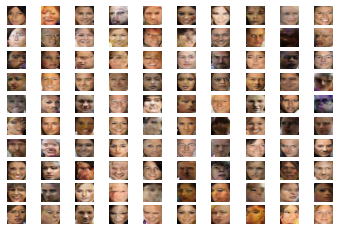

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import savez_compressed

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.savefig('generated_faces.png')
	pyplot.show()
	pyplot.close()

# load model
model = load_model('generator_model_090.h5')
# generate points in latent space
latent_points = generate_latent_points(100, 100)
# save points
savez_compressed('latent_points.npz', latent_points)
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# save plot
plot_generated(X, 10)

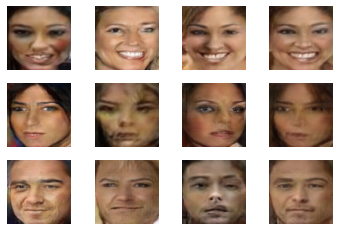

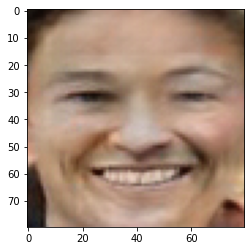

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot
from numpy import load
from numpy import mean
from numpy import vstack
from numpy import expand_dims

# average list of latent space vectors
def average_points(points, ix):
	# convert to zero offset points
	#zero_ix = [i-1 for i in ix]
	zero_ix = ix
	# retrieve required points
	vectors = points[zero_ix]
	# average the vectors
	avg_vector = mean(vectors, axis=0)
	# combine original and avg vectors
	all_vectors = vstack((vectors, avg_vector))
	return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
	# plot images
	for i in range(rows * cols):
		# define subplot
		pyplot.subplot(rows, cols, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = load_model('generator_model_090.h5')
# retrieve specific points
smiling_woman_ix = [5, 9, 57]
neutral_woman_ix = [0, 7, 21]
neutral_man_ix = [32, 33, 34]
# load the saved latent points
data = load('latent_points.npz')
points = data['arr_0']
# average vectors
smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)
# combine all vectors
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
# generate images
images = model.predict(all_vectors)
# scale pixel values
images = (images + 1) / 2.0
plot_generated(images, 3, 4)
# smiling woman - neutral woman + neutral man = smiling man
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()